# VO Pipeline
_Vision Algorithms for Mobile Robotics | Fall 2025_<br><br>
_David Jensen, Alessandro Pirini, Matteo Rubini, Alessandro Ferranti_

## Imports

### Libraries

In [42]:
import os
from glob import glob

from typing import Tuple, Dict

import cv2
import numpy as np
import scipy

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import FancyArrowPatch

### Data
_Ensure that all datasets have been downloaded and unzipped into their respective folders_

In [43]:
# Dataset -> 0: KITTI, 1: Malaga, 2: Parking, 3: Own Dataset
DATASET = 2

In [44]:
# Define dataset paths
# (Set these variables before running)
kitti_path = "kitti/kitti05/kitti"
malaga_path = "malaga/malaga-urban-dataset-extract-07"
parking_path = "parking/parking"
# own_dataset_path = "/path/to/own_dataset"

if DATASET == 0:
    assert 'kitti_path' in locals(), "You must define kitti_path"
    img_dir = os.path.join(kitti_path, '05/image_0')
    images = glob(os.path.join(img_dir, '*.png'))
    last_frame = 4540
    K = np.array([
        [7.18856e+02, 0, 6.071928e+02],
        [0, 7.18856e+02, 1.852157e+02],
        [0, 0, 1]
    ])
    ground_truth = np.loadtxt(os.path.join(kitti_path, 'poses', '05.txt'))
    ground_truth = ground_truth[:, [-9, -1]]  # same as MATLAB(:, [end-8 end])

elif DATASET == 1:
    assert 'malaga_path' in locals(), "You must define malaga_path"
    img_dir = os.path.join(malaga_path, 'malaga-urban-dataset-extract-07_rectified_800x600_Images')
    images = sorted(glob(os.path.join(img_dir, '*.png')))
    last_frame = len(images)
    K = np.array([
        [621.18428, 0, 404.0076],
        [0, 621.18428, 309.05989],
        [0, 0, 1]
    ])
    ground_truth = None
    
elif DATASET == 2:
    assert 'parking_path' in locals(), "You must define parking_path"
    img_dir = os.path.join(kitti_path, '05/image_0')
    images = glob(os.path.join(img_dir, '*.png'))
    last_frame = 598
    K = np.loadtxt(os.path.join(parking_path, 'K.txt'), delimiter=",", usecols=(0, 1, 2))
    ground_truth = np.loadtxt(os.path.join(parking_path, 'poses.txt'))
    ground_truth = ground_truth[:, [-9, -1]]
    
elif DATASET == 3:
    # Own Dataset
    # TODO: define your own dataset and load K obtained from calibration of own camera
    assert 'own_dataset_path' in locals(), "You must define own_dataset_path"

else:
    raise ValueError("Invalid dataset index")

## Parameters

### Parameters for all datasets

In [45]:
# Paramaters for Shi-Tomasi corners
feature_params = dict( maxCorners = 30,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for LKT
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# min squared diff in pxl from a new feature to the nearest existing feature for the new feature to be added
new_feature_min_squared_diff = 5


### Paramaters for specific datasets

In [46]:

# Next keyframe to use for bootstrapping
KITTI_BS_KF = 3
MALAGA_BS_KF = 5
PARKING_BS_KF = 3
CUSTOM_BS_KF = 5

# Number of rows and columns to divide image into for feature detection and number of features to track in each cell
KITTI_ST_ROWS, KITTI_ST_COLS, KITTI_NUM_FEATURES = 2, 4, 20
MALAGA_ST_ROWS, MALAGA_ST_COLS, MALAGA_NUM_FEATURES = 2, 4, 20
PARKING_ST_ROWS, PARKING_ST_COLS, PARKING_NUM_FEATURES = 2, 4, 20
CUSTOM_ST_ROWS, CUSTOM_ST_COLS, CUSTOM_NUM_FEATURES = 2, 4, 20

### Instantiate params class

#### Generate masks for feature tracking

In [47]:
def get_feature_masks(img_path, rows, cols) -> list[np.ndarray]:
    # get image shape
    img = cv2.imread(img_path)
    H, W = img.shape[:2]

    # get boundries of the cells
    row_boundries = np.linspace(0, H, rows + 1, dtype=int)
    col_boundries = np.linspace(0, W, cols + 1, dtype=int)

    # create masks left to right, top to bottom
    masks = []
    for row in range(rows):
        for col in range(cols):
            mask = np.zeros((H, W), dtype="uint8")
            r_s, r_e = row_boundries[[row, row + 1]]
            c_s, c_e = col_boundries[[col, col + 1]]
            mask[r_s:r_e, c_s:c_e] = 255
            masks.append(mask)
            
            # visulaization
            # vis = np.zeros_like(img)
            # vis[mask] = img[mask]
            # cv2.imshow("masked", vis)
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()

    return masks

#### Paramaters

In [48]:
class VO_Params():
    bs_kf_1: str # path to first keyframe used for bootstrapping dataset
    bs_kf_2: str # path to second keyframe used for bootstrapping dataset
    feature_masks: list[np.ndarray] # mask image into regions for feature tracking 
    shi_tomasi_params: dict
    klt_params: dict
    k: np.ndarray # camera intrinsics matrix
    start_idx: int # index of the frame to start continous operation at (2nd bootstrap keyframe index)
    new_feature_min_squared_diff: float # min squared diff in pxl from a new feature to the nearest existing feature for the new feature to be added
    # ADD NEW PARAMS HERE
    alpha: float = 0.11

    def __init__(self, bs_kf_1, bs_kf_2, feature_masks, shi_tomasi_params, klt_params, k, start_idx, new_feature_min_squared_diff):
        self.bs_kf_1 = bs_kf_1
        self.bs_kf_2 = bs_kf_2
        self.feature_masks = feature_masks
        self.shi_tomasi_params = shi_tomasi_params
        self.klt_params = klt_params
        self.k = k
        self.start_idx = start_idx
        self.new_feature_min_squared_diff = new_feature_min_squared_diff
        # ADD NEW PARAMS HERE

if DATASET == 0:
    assert 'kitti_path' in locals(), "You must define kitti_path"
    bs_kf_1 = images[0]
    bs_kf_2 = images[KITTI_BS_KF]
    start_idx = KITTI_BS_KF
    feature_masks = get_feature_masks(bs_kf_1, KITTI_ST_ROWS, KITTI_ST_COLS)
    # ADD NEW PARAMS HERE

elif DATASET == 1:
    assert 'malaga_path' in locals(), "You must define malaga_path"
    bs_kf_1 = images[0]
    bs_kf_2 = images[MALAGA_BS_KF]
    start_idx = MALAGA_BS_KF
    feature_masks = get_feature_masks(bs_kf_1, MALAGA_ST_ROWS, MALAGA_ST_COLS)
    # ADD NEW PARAMS HERE

elif DATASET == 2:
    assert 'parking_path' in locals(), "You must define parking_path"
    bs_kf_1 = images[0]
    bs_kf_2 = images[PARKING_BS_KF]
    start_idx = PARKING_BS_KF
    feature_masks = get_feature_masks(bs_kf_1, PARKING_ST_ROWS, PARKING_ST_COLS)
    # ADD NEW PARAMS HERE

elif DATASET == 3:
    # Own Dataset
    # TODO: define your own dataset and load K obtained from calibration of own camera
    assert 'own_dataset_path' in locals(), "You must define own_dataset_path"

else:
    raise ValueError("Invalid dataset index")

# ADD NEW PARAMS HERE TO THE INIT
params = VO_Params(bs_kf_1, bs_kf_2, feature_masks, feature_params, lk_params, K, start_idx, new_feature_min_squared_diff)

# Initialization
- Select two keyframes with large enough baseline
- Use indirect (feature-based) or direct (KLT) method to establish keypoint corrispondences between frames
- Estimate relative pose and triangulate points to bootstrap point cloud (5-pt RANSAC)
- Initialize VO pipeline with inlier keypoints and their associated landmarks

### Initialization,Feature extraction

Detect a set of 2D keypoints in the first bootstrap keyframe (bs_kf_1) that are well distributed across the image.

Implementation:
- We use `cv2.goodFeaturesToTrack` (Shi–Tomasi) to detect corners.
- To avoid clustering of keypoints in high-texture areas, we apply Shi–Tomasi separately in multiple image regions using `params.feature_masks` and then concatenate the results.

Output:
- `st_corners`: array of shape `(N, 1, 2)` (float32), suitable for KLT tracking with `cv2.calcOpticalFlowPyrLK`.


In [49]:
def extractFeatures(params):
    """
    Step 1 (Initialization): detect Shi-Tomasi corners on a grid using feature masks.

    Args:
        params (VO_Params): contains feature_masks and shi_tomasi_params.

    Returns:
        st_corners (np.ndarray): (N, 1, 2) float32 corners for KLT tracking.
    """
    st_corners = np.empty((0, 1, 2), dtype=np.float32)
    img_grayscale = cv2.imread(params.bs_kf_1, cv2.IMREAD_GRAYSCALE)
    for n, mask in enumerate(params.feature_masks):
        features = cv2.goodFeaturesToTrack(img_grayscale, mask=mask, **params.shi_tomasi_params)
        # If no corners are found in this region, skip it
        if features is None: 
            print(f"No features found for mask {n+1}!")
            continue
        # Warn if very few features were found in this region (not necessarily an error)
        if features.shape[0] < 10:
            print(f"Only {features.shape[0]} features found for mask {n+1}!")
        st_corners = np.vstack((st_corners, features))
    return st_corners

# extract features from the first image of the dataset
bootstrap_features_kf_1 = extractFeatures(params)


Only 3 features found for mask 5!
Only 2 features found for mask 7!
Only 6 features found for mask 8!


### Initialization, KLT tracking across intermediate frames

Establish 2D–2D correspondences between the two bootstrap keyframes (bs_kf_1 → bs_kf_2).

Implementation:
- Tracking the detected keypoints using KLT optical flow (`cv2.calcOpticalFlowPyrLK`).
- Instead of tracking directly from keyframe 1 to keyframe 2 in one shot, we track *frame-by-frame* across the intermediate frames,more stable when the motion between keyframes is larger.
- We maintain a boolean mask `still_detected` that keeps track of keypoints successfully tracked at every frame.

Output:
- `points[still_detected]`: tracked keypoints in `bs_kf_2`
- `initial_points`: initial deteced keypoints in `bs_kf_1`
- `still_detected`: boolean mask (relative to the original set) indicating which keypoints survived the entire bootstrap tracking.



In [50]:
def trackForwardBootstrap(params, st_corners_kf_1):
    """
    Module 2-Initialization: track keypoints from bs_kf_1 to bs_kf_2 with KLT across intermediate frames.

    Args:
        params (VO_Params): contains bs_kf_1, bs_kf_2, klt_params.
        st_corners_kf_1 (np.ndarray): (N,1,2) keypoints in bs_kf_1.

    Returns:
        initial_points[still_detected] (np.ndarray): (N,1,2) points in bs_kf_1 that were tracked to the next keyframe.
        points[still_detected] (np.ndarray): (M,1,2) tracked points in bs_kf_2.
    """
    img_bs_kf_1_index=images.index(params.bs_kf_1)
    img_bs_kf_2_index=images.index(params.bs_kf_2)
    still_detected=np.ones(st_corners_kf_1.shape[0],dtype=bool)
    points = st_corners_kf_1.copy()
    initial_points = st_corners_kf_1.copy()
    #Track keypoints frame-by-frame from first bs frame to second bs frame
    for i in range(img_bs_kf_1_index, img_bs_kf_2_index):
        current_image=cv2.imread(images[i],cv2.IMREAD_GRAYSCALE)
        next_image=cv2.imread(images[i+1],cv2.IMREAD_GRAYSCALE)
        nextPts,status,error=cv2.calcOpticalFlowPyrLK(current_image,next_image,points, None, **params.klt_params)
        points=nextPts
        status=status.flatten()
        still_detected=still_detected & (status==1)

    # Keep only points that were successfully tracked throughout
    return initial_points[still_detected], points[still_detected]


# track extracted features forward to the next keyframe in the dataset
bootstrap_tracked_features_kf_1, bootstrap_tracked_features_kf_2 = trackForwardBootstrap(params, bootstrap_features_kf_1)

### Transformation
TODO: find transformation between the two frames using cv2.findHomography()

### Initialization, Relative pose estimation with RANSAC

Estimate the relative camera motion between the two bootstrap keyframes using
2D–2D correspondences obtained after KLT tracking.

Since the tracked correspondences still contain outliers, we  estimate the epipolar geometry using RANSAC.

Procedure:
1. Estimate the Fundamental matrix using `cv2.findFundamentalMat` with RANSAC.
2. Convert the Fundamental matrix into the Essential matrix using camera intrinsics.
3. Recover the relative rotation and translation (up to scale) using `cv2.recoverPose`.
4. Keep only inlier correspondences.

The resulting relative pose (R, t) is returned together with inliers bollean mask.

In [51]:
def ransacHomography(params, points1, points2):
    """
    Estimate relative pose between two keyframes using RANSAC.

    Args:
        params (VO_Params): contains bs_kf_1, bs_kf_2, klt_params.
        points1, points2: corresponding 2D points (N,2) or (N,1,2)

    Returns:
        H (3x4): relative transformation matrix
        points1[inliers] (N, 1, 2): inlier points from first keyframe
        points2[inliers] (N, 1, 2): inlier points from second keyframe
    """
    #F mat using ransac
    fundamental_matrix, inliers =cv2.findFundamentalMat(points1,points2,cv2.FM_RANSAC,ransacReprojThreshold=1.0)

    #using boolean vector
    inliers = inliers.ravel().astype(bool)

    #compute the essential matrix
    E= K.T@ fundamental_matrix@K

    #recover the relative camera pose
    _,R,t,mask_pose=cv2.recoverPose(E,points1[inliers],points2[inliers],K)

    return np.hstack((R, t)), points1[inliers, :, :], points2[inliers, :, :]


# calculate the homographic transformation between the first two keyframes
homography, ransac_features_kf_1, ransac_features_kf_2 = ransacHomography(params, bootstrap_tracked_features_kf_1, bootstrap_tracked_features_kf_2)

Only 3 features found for mask 5!
Only 2 features found for mask 7!
Only 6 features found for mask 8!
Initial corners: 130
Tracked corners: 130
Inliers after RANSAC: 74591.0 / 102
H:
 [[ 0.99999162  0.0034341   0.00222822 -0.52673338]
 [-0.00345771  0.99993697  0.01068214  0.13518147]
 [-0.0021914  -0.01068975  0.99994046 -0.83921268]]


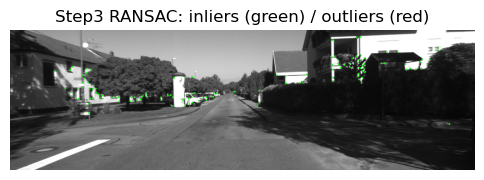

In [52]:
#check point 1 and point 2 and point 3
#read bootstrap keyframes
img_bs_kf_1 = cv2.imread(params.bs_kf_1,cv2.IMREAD_GRAYSCALE)
img_bs_kf_2 = cv2.imread(params.bs_kf_2,cv2.IMREAD_GRAYSCALE)

#1)extract features
st_corners_kf_1 = extractFeatures(params)

#2)KLT interframe tracking
st_corners_kf_1, st_corners_kf_2 = trackForwardBootstrap(params, st_corners_kf_1)

print("Initial corners:",st_corners_kf_1.shape[0])
print("Tracked corners:",st_corners_kf_2.shape[0])


# 3)estimate relative pose with RANSAC
H, kf_1_inliers, kf_2_inliers = ransacHomography(params, st_corners_kf_1, st_corners_kf_2)

print("Inliers after RANSAC:", kf_1_inliers.sum(), "/", len(kf_1_inliers))
print("H:\n", H)

# Visual test: inliers (green) vs outliers (red) on keyframe 1
vis = cv2.cvtColor(img_bs_kf_1, cv2.COLOR_GRAY2BGR)
pts1 = st_corners_kf_1.reshape(-1, 2)

for i, (x, y) in enumerate(pts1):
    color = (0, 255, 0) # if inliers[i] else (0, 0, 255)
    cv2.circle(vis, (int(x), int(y)), 2, color, -1)


import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.imshow(vis[..., ::-1])  # BGR -> RGB
plt.title("Step3 RANSAC: inliers (green) / outliers (red)")
plt.axis("off")
plt.show()

In [53]:
# print("Inlier ratio:", inliers.sum() / len(inliers))
# print("||t||:", np.linalg.norm(t))

### Triangulate points to get point cloud
TODO: find 3d points using triangulatePoints(); the projection matrices are $K*[R|T]$ where $[R|T]$ is $[I|0]$ for the first image and the homography from above for the second image

In [54]:
def bootstrapPointCloud(params: VO_Params, H: np.ndarray, points_1: np.ndarray, points_2: np.ndarray) -> np.ndarray:
    """Bootstrap the initial 3D point cloud using least squares assuming the first frame is the origin

    Args:
        params (VO_Params): params object for the dataset being used
        H (np.ndarray): homographic transformation from bootstrap keyframe 1 to 2
        points_1 (np.ndarray): keypoints detected in bootstrap keyframe 1
        points_2 (np.ndarray): keypoints tracked in bootstrap keyframe 2

    Returns:
        np.ndarray: [3 x k] array of triangulated points
    """
    # projection matrices
    proj_1 = params.k @ np.hstack([np.eye(3), np.zeros((3,1))])
    proj_2 = params.k @ H

    # triangulate homogeneous coordinates using DLT
    points_homo = cv2.triangulatePoints(proj_1, proj_2, points_1, points_2)

    # convert back to 3D
    points_3d = (points_homo[:3, :]/points_homo[3, :])

    return points_3d


# triangulate features from the first two keyframes to generate initial 3D point cloud
bootstrap_point_cloud = bootstrapPointCloud(params, homography, ransac_features_kf_1, ransac_features_kf_2)

### Build state to initialize the algorithm
The state is $(P^i, X^i, C^i, F^i, \Tau^i)$ where<br>
$P^i$ is a `[k x 1 x 2]` matrix of initial features' pixel in the second keyframe of the dataset<br>
$X^i$ is a `[3 x k]` matrix of the 3D cooridinates of the corrisponding landmarks<br>
$C^i$ is a `[m x 1 x 2]` matrix of current locations of candidate keypoints (empty to start so `m=0`)<br>
$F^i$ is a `[m x 1 x 2]` matrix of initial observation of candidate keypoints (empty to start so `m=0`)<br>
$\Tau^i$ is a `[m x 12]` matrix of the camera pose during the initial observation (empty at the start so `m=0`)<br>
This can be stored in a dict $S = \{P: [k \times 1 \times 2], X: [3 \times k], ...\}$

In [55]:
def bootstrapState(P_i: np.ndarray, X_i: np.ndarray) -> dict[str : np.ndarray]:
    """
        Builds the initial state taking the 2D keypoints and their respective 3D points generated by the bootstrap
        
        Args:
            P_i: kx1x2 matrix of 2D keypoints found from the first two frames
            X_i: 3xk matrix containing the 3D projections of the keypoints
        
        Returns:
            dictionary of dictionaries, where every variable of interest is a key and its value is the matrix (e.g. S["P"] returns a kx1x2 matrix of keypoints)  
    """
    S : dict[str : np.ndarray] = {}
    assert P_i.shape[0] == X_i.shape[1], "2D keypoints number of rows should match the 3D keypoints number of columns"
    
    S["P"] = P_i    
    S["X"] = X_i    
    S["C"] = np.empty((0,1,2))
    S["F"] = np.empty_like(S["C"])
    S["T"] = np.empty((0,12))

    return S

# generate initial state
S = bootstrapState(P_i=ransac_features_kf_2, X_i=bootstrap_point_cloud)

# Operation
- Match keypoints in current image to existing landmarks
    - Extract keypoints (Harris)
    - Track (KLT)
- Estimate pose
    - Estimate pose and handle outliers (P3P plus RANSAC)
- Add new landmarks as needed by triangulating new features
    - Keep track of candidate landmarks
        - Keypoint itself
        - Observation when first seen
        - Pose when first seen
    - Only add when they have been tracked for long enough and baselineis large enough
    - Discard if track fails<br>

_NOTE: this starts at the frame after the second keyframe (`bs_kf_2`) and goes until the last frame in the dataset_


### Track keypoints forward one frame
Here we want to use cv2.calcOpticalFlowPyrLK() with previous frame, current frame, $P^i$ and $C^i$,  - see use in initialization for example and then update $P^i$ and $X^i$ as well as $C^i$, $F^i$ and $\Tau^i$ based on the features that were successfully tracked (ie remove any features that were not tracked)

In [56]:
def trackForward(params: VO_Params, state: dict[str:np.ndarray], img_1: np.ndarray, img_2: np.ndarray) -> dict[str:np.ndarray]:
    """
    Track 2D keypoints from img_1 to img_2 using KLT optical flow

    Args:
        params (VO_Params): parameters for the VO pipeline
        img_1 (np.ndarray): first image (grayscale)
        img_2 (np.ndarray): second image (grayscale)
        points_1 (np.ndarray): keypoints in img_1 to be tracked
    Returns:
        np.ndarray: tracked keypoints in img_2
    """
    # NOTE: might make sense to replace assert with ifs since maybe even if we have no points nor candidates we still want to return them empty again
    # FIRST WE TRACK "ESTABILISHED KEYPOINTS"
    points_2D = state["P"]
    assert points_2D.shape[0] > 0, "There are no keypoints here, we can't track them forward"    

    current_points, status, _ = cv2.calcOpticalFlowPyrLK(prevImg=img_1, nextImg=img_2, prevPts=points_2D, nextPts=None, **params.klt_params)
    status = status.flatten()   # we are going to use them as booleans so maybe we should cast them with astype (?)
    
    # update the state with the current points
    state["P"] = current_points[status == 1]
    state["X"] = state["X"][:, status == 1]  # only get the ones with "true" status and slice them as 3xk
    

    # THEN WE TRACK CANDIDATES - but in the first frame there are no candidates to track other than the established points
    # Therefore 
    candidates = state["C"]
    if candidates.shape[0] != 0:
        current_cands, status_cands, _ = cv2.calcOpticalFlowPyrLK(prevImg=img_1, nextImg=img_2, prevPts=candidates, nextPts=None, **params.klt_params)
        status_cands = status_cands.flatten() # same as above
        
        state["C"] = current_cands[status_cands == 1]

        # initial observations, still have some doubts on these two
        state["F"] = state["F"][status_cands == 1]
        state["T"] = state["T"][status_cands == 1]

    return state

# initialize previous image
last_image = cv2.imread(images[params.start_idx], cv2.IMREAD_GRAYSCALE)
image = cv2.imread(images[params.start_idx + 1], cv2.IMREAD_GRAYSCALE)

# track keypoints forward one frame
S = trackForward(params, S, last_image, image)


In [57]:
def draw_points(img: np.ndarray, pts: np.ndarray, color=(0, 255, 0), r=3):
    """
    Draw keypoints stored as (N,1,2) onto an image
    """
    if pts.size == 0:
        return img

    pts2 = pts[:, 0, :]

    img_out = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for x, y in pts2:
        cv2.circle(img_out, (int(x), int(y)), r, color, -1)

    return img_out

In [58]:
# vis = draw_points(image, S["P"], color=(0, 255, 0))  # established points
# vis = draw_points(vis, S["C"], color=(0, 0, 255))   # candidates
# cv2.imshow("Tracked points", vis)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


### Estimate pose
Here we want to use cv2.solvePnPRansac() with updated $P^i$, $X^i$, $K$, to find pose of camera at current position and then update $P^i$ and $X^i$ with the inliers at the end

In [59]:
def estimatePose(params: VO_Params, state: dict[str:np.ndarray]) -> tuple[dict[str:np.ndarray], np.ndarray]:
    """
    Estimate camera pose using PnP RANSAC and update state to keep only inliers
    
    Args:
        params (VO_Params): parameters for the VO pipeline
        state (dict): current state that also contains 2D keypoints and 3D points
    
    Returns:
        tuple[dict, np.ndarray]: updated state with only inliers for P and X and camera pose as 3x4 matrix
    """
    
    pts_2D = state["P"][:, 0, :]
    pts_3D = state["X"]
    pts_3D = pts_3D.T # according to documentation we need them as kx3 not 3xk
    K = params.k
    
    success, r_vec, t_vec, inliers_idx =  cv2.solvePnPRansac(
        objectPoints=pts_3D,
        imagePoints=pts_2D,
        cameraMatrix=K,
        distCoeffs=None,
        flags=cv2.SOLVEPNP_EPNP,
        reprojectionError=2.0,
        confidence=0.999,
        iterationsCount=100
    )

    if not success:
        print("Pose estimation failed")
        print(r_vec, t_vec)
        return ({}, np.zeros((3,4))) # maybe we could raise an error instead of returning this
    
    # r_vec needs to be converted into a 3x3
    R, _ = cv2.Rodrigues(r_vec)    
    camera_pose = np.hstack((R, t_vec))
    
    # now, inliers are the indices in pts_2d and pts_3d corresponding to the inliers; it is a 2D since openCV returns it as such, so we need to convert it in a 1D array to use np features
    inliers_idx = inliers_idx.flatten()
    new_state = state.copy()
    # by doing the following thing the idea is that we are only keeping the inliers
    new_state["P"] = state["P"][inliers_idx]
    new_state["X"] = state["X"][:, inliers_idx] # slice this since we want it as a 3xk
    
    return (new_state, camera_pose)

# estimate pose, only keeping inliers from PnP with RANSAC
S, pose = estimatePose(params, S)

### Try triangulating
TODO: Check the angle between the the first observation ($X^i$ and $\Tau^i$) of candidate keypoints and the current observation ($C^i$ and current pose) - triangulate features using cv2.triangulatePoints() if angle is above threshold

In [60]:
def tryTriangulating(params: VO_Params, state: dict[str:np.ndarray], cur_pose: np.ndarray) -> dict[str:np.ndarray]:
    """
    Triangulate new points based on the bearing angle threshold to ensure sufficient baseline without relying on scale (ambiguous)
    
    Args:
        params (VO_Params): parameters for the VO pipeline
        state (dict): current state that also contains 2D keypoints and 3D points
        cur_pose (np.ndarray): pose of current frame (3x4 matrix) 
    Returns:
        tuple[dict, np.ndarray]: updated state with only inliers for P and X and camera pose as 3x4 matrix
    """
    #Copy to extract important info and then update Markov State
    new_state = state.copy()

    pts_2D_cur = new_state["C"]  #(m,1,2)
    pts_2D_first_obs = new_state["F"] #(m,1,2)
    pts_2D_cur = pts_2D_cur.squeeze(1)  #(m,2)
    pts_2D_first_obs = pts_2D_first_obs.squeeze(1)  #(m,2)
    m = pts_2D_cur.shape[0]
    if pts_2D_first_obs.shape[0] != m: 
        print("ERROR in shapes of tracked keypoints")

    pts_2D_cur_hom = np.column_stack((pts_2D_cur, np.ones(m)))
    pts_2D_first_obs_hom = np.column_stack((pts_2D_first_obs, np.ones(m)))
    K = params.k
    K_inv = np.linalg.inv(K)
    n_pts_2D_cur = K_inv@pts_2D_cur_hom.T #(3,m)
    n_pts_2D_first_obs = K_inv@pts_2D_first_obs_hom.T #(3,m)
    
    first_poses_mat = state["T"].copy()  #flattened on C order (m,12)
    first_poses_mat_tensor = first_poses_mat.reshape(m, 3, 4) #(m,3,4)
    t_f_obs = first_poses_mat_tensor[:, :, -1] #(m,3)
    R_f_obs = first_poses_mat_tensor[:, :, :-1] #(m,3,3)

    #Project all the candidate points that have been tracked up to now
    t = cur_pose[:, -1]
    R_inv = cur_pose[:, :-1].T

    pts_3d_cur = R_inv @ (n_pts_2D_cur-t[:, None]) #(3,m) each is a vector in the world's coordinate frame
    
    #Transform it into a vector expressed in the world frame but going from camera pose to point: i.e. subtract the translation
    cur_to_kp = pts_3d_cur - t[:, None] #(3,m)
    cur_to_kp = cur_to_kp.T #(m,3)

    #Project all the points at their first observation
    n_pts_2D_first_obs = n_pts_2D_first_obs.T[:, :, None] #add dimension for batching (m,3,1)
    t_f_obs = t_f_obs[:,:,None] #(m,3,1)
    R_f_obs_inv = R_f_obs.transpose(0,2,1) #(m,3,3)

    pts_3d_first_obs = R_f_obs_inv @ (n_pts_2D_first_obs-t_f_obs) #(m,3,1)
    pts_3d_first_obs = pts_3d_first_obs.squeeze(-1) #(m,3) each is a vector in the world's coordinate frame
    
    #Transform it into a vector expressed in the world frame but going from camera pose to point: i.e. subtract the translation
    first_to_kp = pts_3d_first_obs - t_f_obs.squeeze(-1) #(m,3)
    
    #Compute bearing angle between the projections
    #Extract x-z plane coordinates
    cur_to_kp_xz = np.column_stack((cur_to_kp[:,0], cur_to_kp[:,2])) #(m,2)
    first_to_kp_xz =  np.column_stack((first_to_kp[:,0], first_to_kp[:,2])) #(m,2)
    
    #Compute norms to normalize vectors
    cur_norms = np.linalg.norm(cur_to_kp_xz, axis = 1)
    first_norms = np.linalg.norm(first_to_kp_xz, axis = 1)

    #Normalize vectors
    cur_to_kp_xz /= cur_norms #(m,2)
    first_to_kp_xz /= first_norms #(m,2)
    
    x_axis = np.array([1, 0])
    cur_c_beta = np.dot(cur_to_kp_xz, x_axis) 
    first_c_gamma = np.dot(first_to_kp_xz, x_axis)

    cur_beta = np.arccos(cur_c_beta)
    first_gamma = np.arccos(first_c_gamma)

    alpha = abs(cur_beta - first_gamma)
    
    #Find indices of where alpha exceeds the threshold
    idx = np.where(alpha > params.alpha)[0]
    not_idx = np.where(alpha <= params.alpha)[0]

    
    #Extract the corresponding matrices
    poses = first_poses_mat[idx]
    valid_pts_2D_first = pts_2D_first_obs[idx, :]
    valid_pts_2D_cur = pts_2D_cur[idx, :]
    
    rounded_poses = np.round(poses, decimals=6)
    
    #Find the indices where the transformation is the same as well as the unique poses
    unique_poses, inverse_idx = np.unique(rounded_poses, axis=0, return_inverse=True)

    #Regroup those having the same camera pose
    groups = [np.where(inverse_idx == i)[0] for i in range(len(unique_poses))] #the indices in the rounded poses for which the transformation is the same

    #Current projection matrix
    proj_2 = K @ cur_pose
    
    for i, g in enumerate(groups):
        proj_1 = unique_poses[i].reshape(3,4)
        valid_pts_1 = valid_pts_2D_first[g].T #(2,k)
        valid_pts_2 = valid_pts_2D_cur[g].T #(2,k)
        points_homo = cv2.triangulatePoints(proj_1, proj_2, valid_pts_1, valid_pts_2)
        # convert back to 3D
        points_3d = (points_homo[:3, :]/points_homo[3, :]) #(3,k)
        
        pixel_coords = valid_pts_2.T  #(k,2)
        pixel_coords = pixel_coords[:, None, :] #Add dimension for consistency (k,1,2)
        new_state["P"] = np.concatenate((new_state["P"], pixel_coords), axis=0) #(n+k,1 ,2)
        new_state["X"] = np.concatenate((new_state["X"], points_3d), axis = 1) #(3, n+k)
    
    #Update the candidate set removing the now triangulated points 
    new_state["C"] = pts_2D_cur[not_idx, None, :]
    new_state["F"] = pts_2D_first_obs[not_idx, None, :]
    new_state["T"] = first_poses_mat[not_idx, :]
    
    return new_state

# attempt triangulating candidate keypoints, only adding ones with sufficient baseline
S = tryTriangulating(params, S, pose)

ValueError: operands could not be broadcast together with shapes (0,2) (0,) (0,2) 

### Find new features
TODO: use cv2.goodFeaturesToTrack() - see use in initialization for example

In [ ]:
def extractFeaturesOperation(params, img_grayscale):
    """
    Step 1 (Initialization): detect Shi-Tomasi corners on a grid using feature masks to find new candidate keypoints.

    Args:
        img_grayscale (np.ndarray): current frame in grayscale (H x W).
        params (VO_Params): contains feature_masks and shi_tomasi_params.

    Returns:
        potential_kp_candidates (np.ndarray): (N, 1, 2) float32 corners for KLT tracking.
    """
    potential_kp_candidates = np.empty((0, 1, 2), dtype=np.float32)
    for n, mask in enumerate(params.feature_masks):
        features = cv2.goodFeaturesToTrack(img_grayscale, mask=mask, **params.shi_tomasi_params)
        # If no corners are found in this region, skip it
        if features is None: 
            print(f"No features found for mask {n+1}!")
            continue
        # Warn if very few features were found in this region (not necessarily an error)
        if features.shape[0] < 10:
            print(f"Only {features.shape[0]} features found for mask {n+1}!")
        potential_kp_candidates = np.vstack((potential_kp_candidates, features))
    
    return potential_kp_candidates

### Add new features
TODO: if the feature is not already being tracked as an actual keypoint or candidate keypoint, update $C^i$ and $X^i$ with keypoint location and $\Tau^i$ with the current camera pose

In [ ]:
def keypoints2set(keypoints: np.ndarray) -> set:
    """Convert numpy keypoint list [k x 1 x 2] to a set of keypoints

    Args:
        keypoints (np.ndarray): keypoint array

    Returns:
        set: keypoint set
    """
    return set([(row[0][0], row[0][1]) for row in keypoints.tolist()])

def set2keypoints(keypoint_set: set) -> np.ndarray:
    """Convert keypoint set (u, v) to a numpy array [k x 1 x 2]

    Args:
        keypoint_set (set): keypoint set

    Returns:
        np.ndarray: keypoint array with shape [k x 1 x 2]
    """
    return np.array([[[keypoint[0], keypoint[1]]] for keypoint in keypoint_set])

def addNewFeatures(params: VO_Params, S: dict, potential_candidate_features: np.ndarray, cur_pose: np.ndarray) -> dict:
    """Given an array of features, update S with featurees that are not already being tracked

    Args:
        params (VO_Params): params object for the dataset being used
        S (dict): state
        potential_candidate_features (np.ndarray): features extracted from current frame
        cur_pose (np.ndarray): pose of current frame

    Returns:
        dict: updated state
    """
    S_old = S.copy()

    # setup
    cur = np.vstack((S["P"], S["C"]))[:, 0, :]
    new = potential_candidate_features[:, 0, :]

    # calculate the squared differences between every point pair (rows corrispond to new features, cols to cur features)
    dists = np.linalg.norm((new[:, None, :] - cur[None, :, :]), axis=2)

    # for every new point, find the distance to the closest current point
    min_dists = np.min(dists, axis=1)

    # create a mask, keeping only features that are greater than a minimum distance from any already tracked feature
    new_features_mask = np.where(min_dists > params.new_feature_min_squared_diff, True, False)

    # mask the potential new features so only unique ones are kept
    new_features = potential_candidate_features[new_features_mask, :, :]
    print(new_features.shape)
    print(cur_pose.flatten()[None, :].repeat(new_features.shape[0], axis=0))

    # append new features to current points, first observed points, and first observed camera pose
    S["C"] = np.vstack((S_old["C"], new_features))
    S["F"] = np.vstack((S_old["F"], new_features))
    S["T"] = np.vstack((S_old["T"], cur_pose.flatten()[None, :].repeat(new_features.shape[0], axis=0)))
    return S

# Plotting
_Thanks to our good friend ChatGPT_

In [ ]:
plt.ion()

def initTrajectoryPlot(gt_path: np.ndarray, arrow_len: float = 0.3) -> Dict[str, object]:
    """
    Initialize trajectory plot with ground truth and placeholders
    for estimated trajectory and camera orientation.

    Args:
        gt_path (np.ndarray): Ground truth path [n x 2]
        arrow_len (float): Length of orientation arrow (meters)

    Returns:
        dict: plot state dictionary
    """
    fig, ax = plt.subplots(figsize=(8, 6))

    if DATASET in [0, 2]:
        # ---- Ground truth (time-colored) ----
        x_gt, y_gt = gt_path[:, 0], gt_path[:, 1]
        t = np.arange(len(gt_path))

        points = np.stack((x_gt, y_gt), axis=1).reshape(-1, 1, 2)
        segments = np.concatenate((points[:-1], points[1:]), axis=1)

        norm = mpl.colors.Normalize(vmin=t.min(), vmax=t.max())
        lc = LineCollection(segments, cmap="viridis", norm=norm, linewidth=2.5)
        lc.set_array(t)

        ax.add_collection(lc)
        cbar = fig.colorbar(lc, ax=ax)
        cbar.set_label("Time step (GT)")

    # ---- Estimated trajectory ----
    est_line, = ax.plot([], [], "r-", linewidth=2, label="VO estimate")
    est_point, = ax.plot([], [], "ro", markersize=5)

    # ---- Orientation arrow ----
    heading_arrow = FancyArrowPatch(
        (0.0, 0.0),
        (0.0, 0.0),
        arrowstyle="->",
        linewidth=2,
        color="red",
        mutation_scale=15,
    )
    ax.add_patch(heading_arrow)

    # ---- Formatting ----
    ax.set_title("Ground Truth vs VO Estimated Trajectory")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.axis("equal")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

    ax.autoscale()
    plt.tight_layout()
    plt.show()

    return {
        "fig": fig,
        "ax": ax,
        "est_line": est_line,
        "est_point": est_point,
        "heading_arrow": heading_arrow,
        "arrow_len": arrow_len,
    }

In [ ]:
def updateTrajectoryPlot(plot_state: Dict[str, object], est_path: np.ndarray, theta: float) -> None:
    """
    Update estimated trajectory and camera orientation arrow.

    Args:
        plot_state (dict): Plot state returned by initTrajectoryPlot
        est_path (np.ndarray): Estimated path [k x 2]
        theta (float): Current yaw angle (radians)
    """
    x = est_path[:, 0]
    y = est_path[:, 1]

    # Update trajectory
    plot_state["est_line"].set_data(x, y)
    plot_state["est_point"].set_data(x[-1], y[-1])

    # Update orientation arrow
    x0, y0 = x[-1], y[-1]
    L = plot_state["arrow_len"]
    x1 = x0 + L * np.cos(theta)
    y1 = y0 + L * np.sin(theta)

    plot_state["heading_arrow"].set_positions((x0, y0), (x1, y1))

    plt.pause(0.001)

# Real-Time Checking

## Bootstrapping

In [ ]:
# extract features from the first image of the dataset
bootstrap_features_kf_1 = extractFeatures(params)

# track extracted features forward to the next keyframe in the dataset
bootstrap_tracked_features_kf_1, bootstrap_tracked_features_kf_2 = trackForwardBootstrap(params, bootstrap_features_kf_1)

# calculate the homographic transformation between the first two keyframes
homography, ransac_features_kf_1, ransac_features_kf_2 = ransacHomography(params, bootstrap_tracked_features_kf_1, bootstrap_tracked_features_kf_2)

# triangulate features from the first two keyframes to generate initial 3D point cloud
bootstrap_point_cloud = bootstrapPointCloud(params, homography, ransac_features_kf_1, ransac_features_kf_2)

# generate initial state
S = bootstrapState(P_i=ransac_features_kf_2, X_i=bootstrap_point_cloud)

## Looping

In [ ]:
# ploting setup
plot_state = initTrajectoryPlot(ground_truth)
est_path = []
theta = 0.0

# initialize previous image
last_image = cv2.imread(images[params.start_idx], cv2.IMREAD_GRAYSCALE)
# find features in current frame

#Initialize candidate set with the second keyframe
potential_candidate_features = extractFeaturesOperation(params, last_image)

# find which features are not currently tracked and add them as candidate features
S = addNewFeatures(params, S, potential_candidate_features, homography)

In [ ]:
for i in range(params.start_idx + 1, last_frame + 1):

    # read in next image
    image_path = images[i]
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Warning: could not read {image_path}")
        continue

    # track keypoints forward one frame
    S = trackForward(params, S, last_image, image)

    # estimate pose, only keeping inliers from PnP with RANSAC
    S, pose = estimatePose(params, S)

    # attempt triangulating candidate keypoints, only adding ones with sufficient baseline
    S = tryTriangulating(params, S, pose)

    # find features in current frame
    potential_candidate_features = extractFeaturesOperation(params, image)

    # find which features are not currently tracked and add them as candidate features
    S = addNewFeatures(params, S, potential_candidate_features, pose)

    # plot current pose
    est_path.append(pose[:2, 3])
    theta = scipy.spatial.transform.Rotation.from_matrix(pose[:3, :3]).as_euler("xyz")[1]
    updateTrajectoryPlot(plot_state, np.asarray(est_path), theta)

    # update last image
    last_image = image

    # pause for 0.01 seconds
    cv2.waitKey(10)

cv2.destroyAllWindows()